# **EECE 490 Hackathon:**
### Mohamad Baghdadi Jenny El Khazen

In [47]:
!pip install deep_translator

# **Data Cleanup and preparation:**
Given that this data contains cells in arabic, we will first work on extracting them and translating before we start encoding.
After extracting, now we translate to english using deep translator's google translate

In [48]:
import pandas as pd
from deep_translator import GoogleTranslator
import re

# Load your dataset
df = pd.read_csv('2024_PersonalityTraits_SurveyData.csv')

# Function to check for Arabic text
def contains_arabic(text):
    try:
        return bool(re.search(r'[\u0600-\u06FF]', str(text)))
    except:
        return False

# Function to translate Arabic text to English
def translate_to_english(text):
    if pd.isna(text):  # Check for NaN values
        return text
    try:
        translated = GoogleTranslator(source='ar', target='en').translate(text)
        return translated
    except Exception as e:
        print(f"Error translating '{text}': {e}")
        return text

# Identify and translate columns containing Arabic text
for column in df.columns:
    if df[column].apply(contains_arabic).any():
        df[column] = df[column].apply(translate_to_english)

# Save the translated DataFrame to a new CSV file
df.to_csv('Translated_PersonalityTraits_SurveyData.csv', index=False)


# **Filtering the columns that can/cannot be encoded so we can start building our model, and re-naming the colunmns for easiness and clarity**



In [49]:
cols_to_drop = [
    "What is your favorite or preferred cigarette brand(s) if you were able to access it?",
    "What cigarette brand(s) are you currently using?",
    "What is your current employment status? [Comment]",
    "What is your current marital status? [Comment]",
    "What is your main source of income? [Comment]",
    "What type of income or financial support does your household receive? [Comment]"
]
df1 = df.copy()
df1 = df1.drop(columns=cols_to_drop)


In [50]:
# Dictionary mapping old column names to new ones
column_name_map = {
    "Unnamed: 0": "ID",
    "Sector": "Sector",
    "Last page": "LastPage",
    "Have you smoked at least one full tobacco cigarette (excluding e-cigarettes) once or more in the past 30 days?": "SmokedIn30Days",
    "I see myself as someone who is extraverted, enthusiastic:": "Extraverted",
    "I see myself as someone who is critical, quarrelsome:": "Critical",
    "I see myself as someone who is dependable, self-disciplined:": "Dependable",
    "I see myself as someone who is anxious, easily upset:": "Anxious",
    "I see myself as someone who is open to new experiences:": "OpenExp",
    "I see myself as someone who is reserved, quiet:": "Reserved",
    "I see myself as someone who is sympathetic, warm:": "Sympathetic",
    "I see myself as someone who is disorganized, careless:": "Disorganized",
    "I see myself as someone who is calm, emotionally stable:": "Calm",
    "I see myself as someone who is conventional, uncreative:": "Conventional",
    "Do you find it difficult to refrain from smoking where it is forbidden (church, library, cinema, plane, etc...)?": "DifficultRefrain",
    "How many cigarettes do you smoke each day?": "CigsPerDay",
    "Do you smoke more frequently during the first hours after waking up than during the rest of the day? ": "SmokeMoreEarly",
    "Do you smoke if you are so ill that you are in bed most of the day?": "SmokeWhileIll",
    "How soon after you wake up do you smoke your first cigarette?": "TimeToFirstCig",
    "Which cigarette would you mostly hate to give up?": "HateToGiveUp",
    "How old were you the first time you smoked a full cigarette (not just a few puffs)?": "FirstCigAge",
    "How would you describe your current smoking behavior compared to your smoking behavior before Lebanon's economic crisis and revolution began in 2019?": "SmokingChangePostCrisis",
    "Are you currently able to afford your favorite or preferred cigarette brand(s)?": "AffordFavoriteBrand",
    "Has 2019's revolution or economic crisis caused you to switch away from your favorite or preferred cigarette brand(s) to an  alternative?": "SwitchedBrandPostCrisis",
    "Gender:": "Gender",
    "How old are you?": "Age",
    "Which governerate do you live in or spend most of your time in?": "Governorate",
    "What is the highest level of education you have attained?": "EducationLevel",
    "What is your current employment status?": "CurrentEmploymentStatus",
    "What is your current marital status?": "MaritalStatus",
    "Do you have close friends?": "CloseFriends",
    "Of the five closest friends or acquaintances that you spend time with on a regular basis, how many of them are smokers?": "NumSmokerFriends",
    "What is your main source of income?": "MainIncomeSource",
    "What type of income or financial support does your household receive?": "HouseholdIncomeType",
    "If you receive payment in Lebanese Lira, what is your current estimated monthly household income? (If income is in US Dollars, then refer to the current black market exchange).": "MonthlyIncome",
    "How would you describe your current income sufficiency?": "IncomeSufficiency",
    "Including yourself, how many people currently live in your household?": "HouseholdSize",
    "To what extent were you financially (negatively) affected by the deterioration of the Lebanese economy?": "FinancialImpact",
    "How often do you exercise?": "ExerciseFreq",
    "On average, how many hours per day do you spend on social media for entertainment and social interaction (Facebook, Instagram, YouTube, etc...)?": "SocialMediaHours",
    "How often do you feel stressed?": "StressFreq",
    "Employment Status": "EmploymentStatusGeneral"
}

print(len(column_name_map))

# Apply the rename
df1 = df1.rename(columns=column_name_map)

print(df1)

42
      ID   Sector  LastPage SmokedIn30Days                 Extraverted  \
0      5  Private         5            Yes              Agree strongly   
1     11  Private         5            Yes            Agree moderately   
2     14  Private         5            Yes         Disagree moderately   
3     15  Private         5            Yes              Agree strongly   
4     16  Private         5            Yes              Agree a little   
..   ...      ...       ...            ...                         ...   
207  617   Public         5            Yes            Agree moderately   
208  618   Public         5            Yes            Agree moderately   
209  619   Public         5            Yes           Disagree a little   
210  620   Public         5            Yes            Agree moderately   
211  621   Public         5            Yes  Neither agree nor disagree   

                       Critical        Dependable              Anxious  \
0           Disagree moderately   

# **Now we want to use label-encoding to encode our data so we can start with the model:**

In [51]:
predefined_categories = {
    "Sector": ["Private", "Public", "Other"],
    "SmokedIn30Days": ["Yes", "No"],

    # Personality traits (Likert scale):
    # Based on the snippet, possible responses:
    # "Agree strongly", "Agree moderately", "Agree a little",
    # "Neither agree nor disagree", "Disagree a little",
    # "Disagree moderately", "Disagree strongly"
    "Extraverted": ["Agree strongly","Agree moderately","Agree a little","Neither agree nor disagree","Disagree a little","Disagree moderately","Disagree strongly"],
    "Critical": ["Agree strongly","Agree moderately","Agree a little","Neither agree nor disagree","Disagree a little","Disagree moderately","Disagree strongly"],
    "Dependable": ["Agree strongly","Agree moderately","Agree a little","Neither agree nor disagree","Disagree a little","Disagree moderately","Disagree strongly"],
    "Anxious": ["Agree strongly","Agree moderately","Agree a little","Neither agree nor disagree","Disagree a little","Disagree moderately","Disagree strongly"],
    "OpenExp": ["Agree strongly","Agree moderately","Agree a little","Neither agree nor disagree","Disagree a little","Disagree moderately","Disagree strongly"],
    "Reserved": ["Agree strongly","Agree moderately","Agree a little","Neither agree nor disagree","Disagree a little","Disagree moderately","Disagree strongly"],
    "Sympathetic": ["Agree strongly","Agree moderately","Agree a little","Neither agree nor disagree","Disagree a little","Disagree moderately","Disagree strongly"],
    "Disorganized": ["Agree strongly","Agree moderately","Agree a little","Neither agree nor disagree","Disagree a little","Disagree moderately","Disagree strongly"],
    "Calm": ["Agree strongly","Agree moderately","Agree a little","Neither agree nor disagree","Disagree a little","Disagree moderately","Disagree strongly"],
    "Conventional": ["Agree strongly","Agree moderately","Agree a little","Neither agree nor disagree","Disagree a little","Disagree moderately","Disagree strongly"],

    "DifficultRefrain": ["Yes", "No"],
    "CigsPerDay": ["10 or less cigarettes/day", "11 to 20 cigarettes", "21 to 30 cigarettes", "31 cigarettes/day or more"],

    "SmokeMoreEarly": ["Yes", "No"],
    "SmokeWhileIll": ["Yes", "No"],

    "TimeToFirstCig": ["Within 5 minutes", "6 to 30 minutes", "31 to 60 minutes", "After 60 minutes"],
    "HateToGiveUp": ["The first one in the morning", "All others"],

    # FirstCigAge is numeric, no encoding needed. We'll handle that by leaving it as-is in the code.

    "SmokingChangePostCrisis": [
        "The number of cigarettes I smoke per day has remained the same",
        "The number of cigarettes I smoke per day has increased",
        "The number of cigarettes I smoke per day has decreased"
    ],
    "AffordFavoriteBrand": ["Yes", "No"],
    "SwitchedBrandPostCrisis": [
        "No, I am currently using my favorite or preferred cigarette brand(s)",
        "Yes, I am currently using a cheaper alternative"
    ],
    "Gender": ["Male", "Female", "Other"],

    # Age is numeric, no encoding.

    "Governorate": [
        "Beirut",
        "Mount Lebanon",
        "North Lebanon",
        "South Lebanon",
        "Bekaa",
        "Nabatieh",
        "Akkar",
        "Baalbek-Hermel",
        "Keserwan - Jbeil",
        "Other"  # To handle unexpected values
    ],

    "EducationLevel": [
        "High school degree or equivalent (e.g. GED)",
        "Incomplete bachelor's degree",
        "Bachelor's degree (BA/BS)",
        "Graduate degree (MA/MS)",
        "Post-graduate degree (PhD, MD, or other)",
        "Other"
    ],

    "CurrentEmploymentStatus": [
        "Business owner",
        "Student only",
        "Student with a part-time or full-time job",
        "Employed",
        "Unemployed",
        "Other"
    ],

    "MaritalStatus": [
        "Single",
        "Engaged",
        "In a relationship",
        "Married",
        "Other"
    ],

    "CloseFriends": ["Yes", "No"],

    # NumSmokerFriends is numeric, no encoding needed.

    "MainIncomeSource": [
        "Parents",
        "Own business income",
        "Job",
        "Investment",
        "Other, please specify"
    ],

    "HouseholdIncomeType": [
        "Fully in Lebanese Lira",
        "Fully in US Dollars",
        "Mixed",
        "I don't know",
        "I prefer not to say",
        "Other"
    ],

    "MonthlyIncome": [
        "Between 1 and 4 million L.L",
        "Between 4 and 8 million L.L",
        "Between 8 and 12 million L.L",
        "Between 12 and 16 million L.L",
        "Between 16 and 20 million L.L",
        "More than 20 million L.L",
        "I don't know",
        "Other"
    ],

    "IncomeSufficiency": [
        "Very low income: does not cover basic needs for a month",
        "Low: barely covers basic needs for a month",
        "Medium: covers all basic needs",
        "High: completely covers necessities with a few luxury items",
        "Extremely high: covers a wide range of luxury items",
        "Other"
    ],

    # HouseholdSize is numeric, no encoding.

    "FinancialImpact": ["Not at all", "Slightly", "Moderately", "Very", "Extremely", "Other"],

    "ExerciseFreq": [
        "Never",
        "Sometimes or a few days every month",
        "Often or at least 3 days every week",
        "Every day or at least 5 times every week",
        "Other"
    ],

    "SocialMediaHours": [
        "Less than 1 hour",
        "Between 1 hour and 2 hours",
        "Between 2 and 3 hours",
        "Between 3 and 4 hours",
        "More than 4 hours",
        "Other"
    ],

    "StressFreq": [
        "Never",
        "Occasionally",
        "Frequently",
        "Constantly",
        "Rarely",
        "Other"
    ],

    "EmploymentStatusGeneral": ["Employed", "Unemployed", "Other"]
}


In [52]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assume df is your DataFrame after dropping the free-text columns and renaming columns
df_encoded = df1.copy()

# Identify categorical columns
categorical_columns = df_encoded.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    # Get the predefined categories if available; if not, treat all known as valid + "Other"
    if col in predefined_categories:
        valid_categories = predefined_categories[col]
    else:
        # If not predefined, take the unique values and add "Other"
        unique_vals = df_encoded[col].dropna().unique().tolist()
        valid_categories = unique_vals + ["Other"]

    # Map values to valid categories or "Other"
    df_encoded[col] = df_encoded[col].apply(
        lambda x: x if pd.notna(x) and x in valid_categories else "Other"
    )

    # Label encode
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Numeric columns remain unchanged.

df_encoded.to_csv('LabelEncodedData.csv', index=False)
print("Label encoding completed with predefined categories. Non-matching and missing values mapped to 'Other'.")


Label encoding completed with predefined categories. Non-matching and missing values mapped to 'Other'.


# **We chose CigsPerDay as the first thing we want to predict, let's get the correlations of the features with CigsPerDay to select the most relevant:**

                         CigsPerDay
CigsPerDay                 1.000000
DifficultRefrain           0.576611
SmokeMoreEarly             0.420468
HateToGiveUp               0.405711
ID                         0.384055
SmokeWhileIll              0.379864
NumSmokerFriends           0.352666
HouseholdSize              0.193286
MainIncomeSource           0.145058
Reserved                   0.135251
CurrentEmploymentStatus    0.126062
EmploymentStatusGeneral    0.108203
Sector                     0.097221
Gender                     0.084729
SwitchedBrandPostCrisis    0.076609
Conventional               0.070899
CloseFriends               0.052169
Dependable                 0.041392
SmokingChangePostCrisis    0.041070
MonthlyIncome              0.038895
Sympathetic                0.025565
MaritalStatus              0.014272
FinancialImpact            0.014045
HouseholdIncomeType        0.009924
StressFreq                 0.001417
Extraverted               -0.035423
Calm                      -0

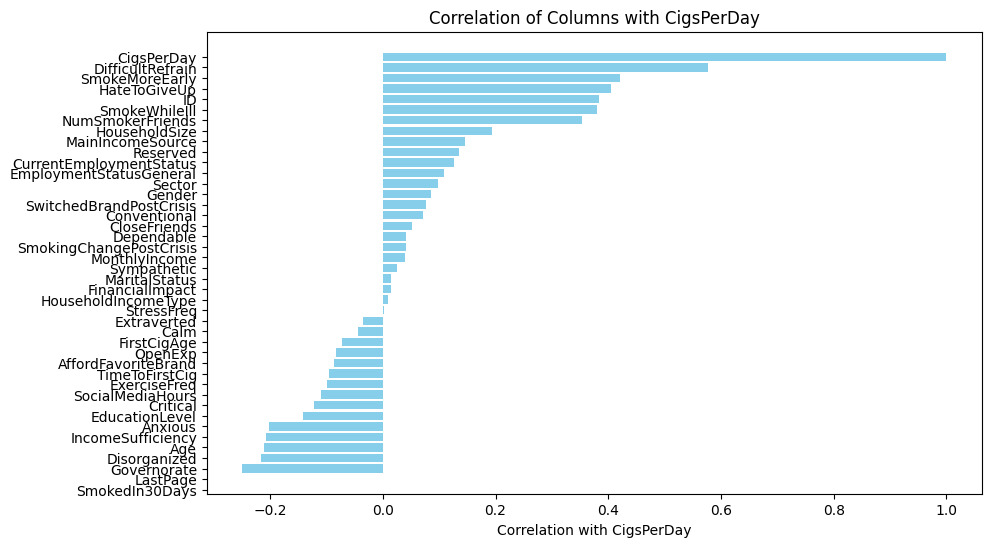

In [53]:
import matplotlib.pyplot as plt
# Calculate the correlation of all columns with 'CigsPerDay'
correlation = df_encoded.corr()

# Extract the correlation values for 'CigsPerDay'
correlation_cigs = correlation[['CigsPerDay']].sort_values(by='CigsPerDay', ascending=False)
print (correlation_cigs)

# Plot the correlation as a bar chart
plt.figure(figsize=(10, 6))
plt.barh(correlation_cigs.index, correlation_cigs['CigsPerDay'], color='skyblue')
plt.xlabel('Correlation with CigsPerDay')
plt.title('Correlation of Columns with CigsPerDay')
plt.gca().invert_yaxis()  # To display the most correlated features at the top
plt.show()

# **Now we select these features (we picked 0.1 to be the threshold but might have to change it later)**

In [54]:
# Initialize an empty list to store relevant feature names
relevantFeatures = []

# Iterate over the correlations of 'CigsPerDay' with each feature
for feature, corr in correlation_cigs.iterrows():
    # Skip the 'ID' column and columns with absolute correlation equal to 1
    if feature == "ID" or abs(corr['CigsPerDay']) == 1:
        continue
    # Select features with an absolute correlation greater than or equal to 0.1
    if abs(corr['CigsPerDay']) >= 0.1:
        relevantFeatures.append(feature)

# Display the list of relevant features
print(relevantFeatures)
print(len(relevantFeatures))

['DifficultRefrain', 'SmokeMoreEarly', 'HateToGiveUp', 'SmokeWhileIll', 'NumSmokerFriends', 'HouseholdSize', 'MainIncomeSource', 'Reserved', 'CurrentEmploymentStatus', 'EmploymentStatusGeneral', 'SocialMediaHours', 'Critical', 'EducationLevel', 'Anxious', 'IncomeSufficiency', 'Age', 'Disorganized', 'Governorate']
18


Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.73      0.62        22
           1       0.64      0.45      0.53        20
           2       0.42      0.36      0.38        14
           3       0.38      0.38      0.38         8

    accuracy                           0.52        64
   macro avg       0.49      0.48      0.48        64
weighted avg       0.52      0.52      0.51        64



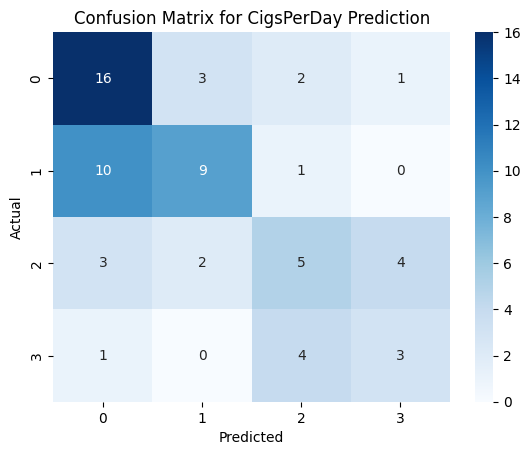

Cross-validation scores: [0.53488372 0.44186047 0.61904762 0.4047619  0.54761905]
Average accuracy: 0.5096345514950166


In [55]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score

# Initialize the scaler
scaler = MinMaxScaler() # turned out to be better than standard (by 2%)

# Filter the dataset to only include relevant features and the target variable (CigsPerDay)
X = df_encoded[relevantFeatures]
y = df_encoded['CigsPerDay']  # Use CigsPerDay directly as target (not binary)

# Fit and transform the feature matrix
X_scaled = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Train Logistic Regression Model (multi-class)
model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model with classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(0, max(y) + 1)], yticklabels=[str(i) for i in range(0, max(y) + 1)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CigsPerDay Prediction')
plt.show()

scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Average accuracy:", scores.mean())

## Logistic Regression Model Performance Analysis

The Logistic Regression model’s classification report and cross-validation results indicate moderate performance at best.


### Overall Metrics

- **Accuracy:** ~0.52  
  The accuracy hovers just above 50%, indicating that the model is only slightly better than random guessing (depending on the distribution of the classes).
  
- **Macro Avg F1-Score:** 0.48  
  The macro average treats each class equally, showing that the model does not perform well on the classes as a whole. It’s indicative that some classes are much harder to predict than others.

- **Weighted Avg F1-Score:** 0.51  
  Considering class distribution, the model’s weighted performance remains modest.

### Cross-Validation Results

- **CV Scores:** [0.5349, 0.4419, 0.6190, 0.4048, 0.5476]  
  These vary significantly, suggesting the model’s performance is sensitive to the particular sample of data it’s trained on.
  
- **Average CV Accuracy:** ~0.51  
  The average accuracy across folds is about 51%, reinforcing that the model’s overall predictive power is limited and not stable across different subsets of the data.

### Interpretation & Next Steps

- The logistic regression model displays the best performance in identifying the lowest-intensity smokers (Class 0) but struggles to accurately classify moderate to heavy smokers.
- The low F1-scores for Classes 2 and 3 suggest the model is not capturing the nuanced differences needed to reliably classify heavier cigarette consumption levels.
- Additional feature engineering, different modeling techniques (e.g.,  gradient boosting, which we will try next)
- Considering the complexity of human behavior factors, a modest accuracy around 50-56% is not unexpected, but it indicates significant room for improvement.


['DifficultRefrain', 'SmokeMoreEarly', 'HateToGiveUp', 'SmokeWhileIll', 'NumSmokerFriends', 'Anxious', 'IncomeSufficiency', 'Age', 'Disorganized', 'Governorate']
10
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.69      0.61        16
           1       0.50      0.42      0.45        12
           2       0.40      0.18      0.25        11
           3       0.12      0.25      0.17         4

    accuracy                           0.44        43
   macro avg       0.39      0.38      0.37        43
weighted avg       0.46      0.44      0.43        43



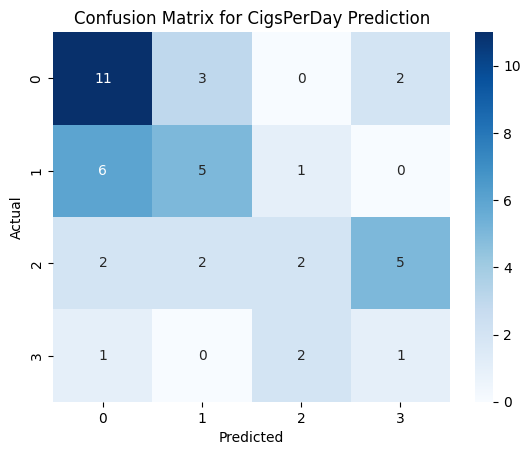

In [76]:
# Initialize an empty list to store relevant feature names
relevantFeatures = []

# Iterate over the correlations of 'CigsPerDay' with each feature
for feature, corr in correlation_cigs.iterrows():
    # Skip the 'ID' column and columns with absolute correlation equal to 1
    if feature == "ID" or abs(corr['CigsPerDay']) == 1:
        continue
    # Select features with an absolute correlation greater than or equal to 0.1
    if abs(corr['CigsPerDay']) >= 0.2:
        relevantFeatures.append(feature)

# Display the list of relevant features
print(relevantFeatures)
print(len(relevantFeatures))

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the scaler
scaler = StandardScaler()

# Filter the dataset to only include relevant features and the target variable (CigsPerDay)
X = df_encoded[relevantFeatures]
y = df_encoded['CigsPerDay']

# Fit and transform the feature matrix
X_scaled = scaler.fit_transform(X)

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42)

# Fit the grid search to the data
model.fit(X_train, y_train)


# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model with classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(0, max(y) + 1)], yticklabels=[str(i) for i in range(0, max(y) + 1)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CigsPerDay Prediction')
plt.show()


# **Trying now XGBoost:**

Selected features based on correlation >= 0.2 with CigsPerDay:
['ID', 'Anxious', 'Disorganized', 'DifficultRefrain', 'SmokeMoreEarly', 'SmokeWhileIll', 'HateToGiveUp', 'Age', 'Governorate', 'NumSmokerFriends', 'IncomeSufficiency']


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:28:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost model accuracy on the test set for CigsPerDay with selected features: 0.56


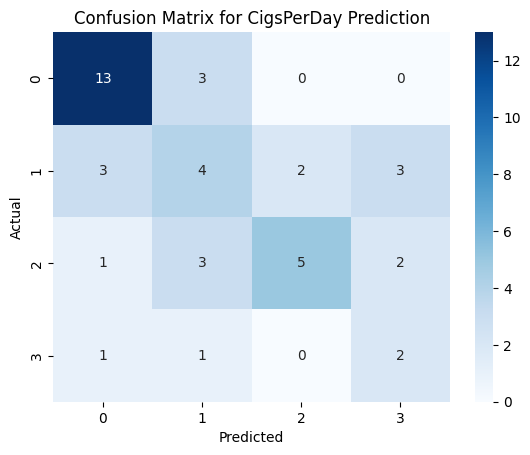

In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Assuming df_encoded is your DataFrame after all preprocessing (dropping columns, encoding, etc.)
# and that "CigsPerDay" is your target variable.

if "CigsPerDay" not in df_encoded.columns:
    raise ValueError("CigsPerDay column not found in DataFrame.")

# Compute correlation of all features with CigsPerDay
correlations = df_encoded.corr(numeric_only=True)["CigsPerDay"].drop("CigsPerDay")

selected_features = correlations[abs(correlations) >= 0.2].index.tolist()
print("Selected features based on correlation >= 0.2 with CigsPerDay:")
print(selected_features)

# Prepare data
X = df_encoded[selected_features]
y = df_encoded["CigsPerDay"]

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost model accuracy on the test set for CigsPerDay with selected features: {accuracy:.2f}")

from sklearn.metrics import confusion_matrix

# After predicting y_pred
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(0, max(y) + 1)], yticklabels=[str(i) for i in range(0, max(y) + 1)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CigsPerDay Prediction')
plt.show()

# **Tuned XGBoost:**

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:30:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}
Improved accuracy with best parameters: 0.56


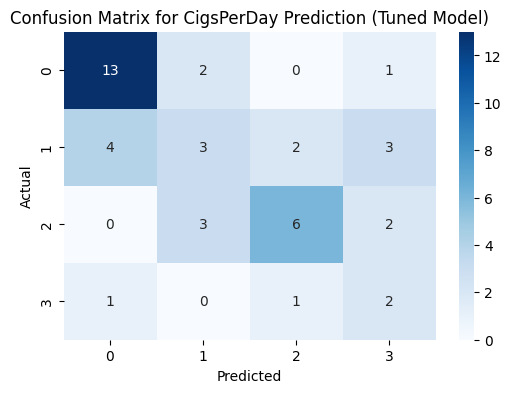

In [96]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBClassifier (no need to specify parameters here)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,  # use all available cores
    cv=5,        # 5-fold cross-validation
    verbose=1
)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by the grid search
print("Best parameters:", grid_search.best_params_)

# Retrieve the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Improved accuracy with best parameters: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in sorted(y.unique())],
            yticklabels=[str(i) for i in sorted(y.unique())])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CigsPerDay Prediction (Tuned Model)')
plt.show()


## Model Performance Analysis

After selecting features based on correlation with the target variable (**CigsPerDay**) and tuning the XGBoost model's hyperparameters using a grid search, the model achieved approximately **56% accuracy** on the test set.

### Interpretation

1. **Baseline Consideration:**  
   To understand whether 56% is good or not, it’s crucial to compare this accuracy against a simple baseline. For instance, if one class (e.g., "10 or less cigarettes/day") dominates the data, predicting that class for all observations might yield a similar or only slightly lower accuracy. If the model's performance is only marginally better than the baseline, it suggests that the features and model may not be capturing strong predictive patterns.

2. **Data Complexity:**  
   Cigarette consumption behavior is influenced by a variety of personal, social, and environmental factors. Even with well-tuned hyperparameters, 56% accuracy might reflect the complexity and variability inherent in the data. The relationships between personality traits, socio-economic indicators, and smoking intensity may not be straightforward.

3. **Feature Selection:**  
   We chose features based solely on correlation with the target. While correlation can help reduce the feature space, it may discard informative features that are not linearly correlated. More sophisticated feature selection or dimensionality reduction techniques (e.g., using feature importance from the model or methods like mutual information) could uncover additional predictors that improve performance.

4. **Further Improvements:**
   - **More Data / Feature Engineering:** Incorporating additional relevant variables or engineering new features that better capture the underlying determinants of smoking behavior may improve accuracy.  
   - **Handle Class Imbalance:** If classes are imbalanced, consider methods like class weighting or oversampling to ensure the model isn't biased towards a dominant class.



# **We will now try to work on TimeToFirstCig**

Selected features based on correlation >= 0.1 with TimeToFirstCig:
['ID', 'Dependable', 'AffordFavoriteBrand', 'Governorate', 'EducationLevel', 'CurrentEmploymentStatus', 'MaritalStatus', 'NumSmokerFriends', 'ExerciseFreq', 'SocialMediaHours']


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:36:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost model accuracy on predicting TimeToFirstCig with selected features: 0.47


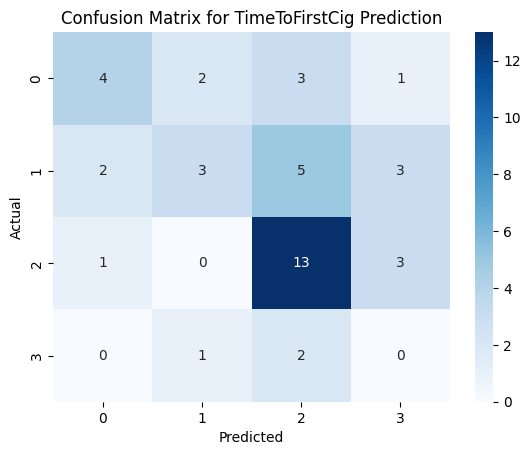

In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Ensure "TimeToFirstCig" is in df_encoded and is numeric/encoded
if "TimeToFirstCig" not in df_encoded.columns:
    raise ValueError("TimeToFirstCig column not found in df_encoded.")

# Compute correlation of all features with TimeToFirstCig
correlations = df_encoded.corr(numeric_only=True)["TimeToFirstCig"].drop("TimeToFirstCig")

# Select features with abs(corr) >= 0.1
selected_features = correlations[abs(correlations) >= 0.1].index.tolist()
print("Selected features based on correlation >= 0.1 with TimeToFirstCig:")
print(selected_features)

# Prepare data
X = df_encoded[selected_features]
y = df_encoded["TimeToFirstCig"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost model accuracy on predicting TimeToFirstCig with selected features: {accuracy:.2f}")
# After predicting y_pred
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(0, max(y) + 1)], yticklabels=[str(i) for i in range(0, max(y) + 1)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for TimeToFirstCig Prediction')
plt.show()


## Quick Analysis

The XGBoost model achieved about **47% accuracy** when predicting "TimeToFirstCig" using features selected by correlation (≥0.1). This result is slightly below a random guess for a balanced 4-class problem (which would be 25%), but still not strongly predictive. The confusion matrix likely shows the model struggles to differentiate between the categories, suggesting the selected features and current approach do not capture the nuances of "TimeToFirstCig" timing. More data, better feature engineering, or ordinal modeling strategies may be needed to improve performance.


# **Trying social media**

                               ID    Sector  LastPage  SmokedIn30Days  \
ID                       1.000000  0.780203       NaN             NaN   
Sector                   0.780203  1.000000       NaN             NaN   
LastPage                      NaN       NaN       NaN             NaN   
SmokedIn30Days                NaN       NaN       NaN             NaN   
Extraverted             -0.020459 -0.012809       NaN             NaN   
Critical                 0.087008  0.146802       NaN             NaN   
Dependable               0.090330  0.092621       NaN             NaN   
Anxious                 -0.020339  0.089225       NaN             NaN   
OpenExp                 -0.060786  0.038989       NaN             NaN   
Reserved                 0.094699 -0.041283       NaN             NaN   
Sympathetic             -0.063596  0.023029       NaN             NaN   
Disorganized            -0.040718  0.018633       NaN             NaN   
Calm                    -0.130159 -0.012880       N

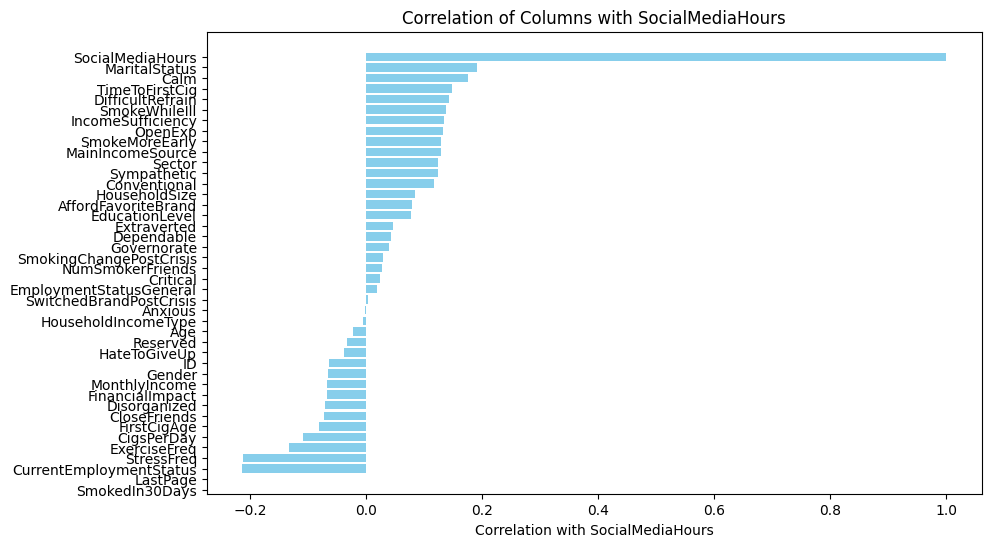

In [103]:
# Calculate the correlation of all columns with 'ExerciseFreq'
correlation = df_encoded.corr()

# Extract the correlation values for 'ExerciseFreq'
correlation_sm = correlation[['SocialMediaHours']].sort_values(by='SocialMediaHours', ascending=False)
print (correlation)

# Plot the correlation as a bar chart
plt.figure(figsize=(10, 6))
plt.barh(correlation_sm.index, correlation_sm['SocialMediaHours'], color='skyblue')
plt.xlabel('Correlation with SocialMediaHours')
plt.title('Correlation of Columns with SocialMediaHours')
plt.gca().invert_yaxis()  # To display the most correlated features at the top
plt.show()

In [107]:
# Initialize an empty list to store relevant feature names
relevantFeatures_sm = []

# Iterate over the correlations of 'CigsPerDay' with each feature
for feature, corr in correlation_sm.iterrows():
    # Skip the 'ID' column and columns with absolute correlation equal to 1
    if feature == "ID" or abs(corr['SocialMediaHours']) == 1:
        continue
    # Select features with an absolute correlation greater than or equal to 0.1
    if abs(corr['SocialMediaHours']) >= 0.2:
        relevantFeatures_sm.append(feature)

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.13      0.20        15
           1       0.39      0.94      0.56        16
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         9

    accuracy                           0.40        43
   macro avg       0.16      0.21      0.15        43
weighted avg       0.29      0.40      0.28        43



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


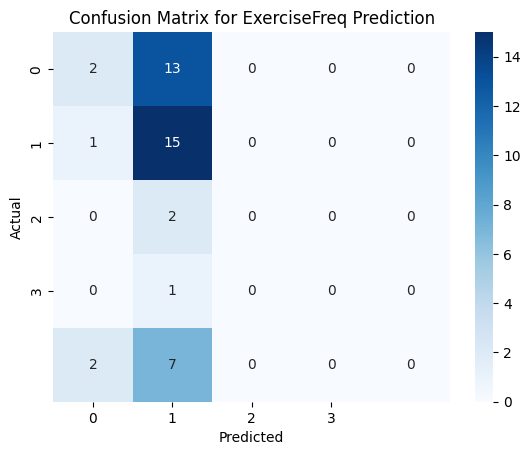

Cross-validation scores: [0.44186047 0.46511628 0.4047619  0.45238095 0.30952381]
Average accuracy: 0.41472868217054265


In [117]:
#LOGREG WITH 0.1

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Initialize the scaler
scaler = MinMaxScaler() # turned out to be better than standard (by 2%)

# Filter the dataset to only include relevant features and the target variable
X_sm = df_encoded[relevantFeatures_sm]
y_sm = df_encoded['SocialMediaHours']  # Use ExerciseFreq directly as target (not binary)

# Fit and transform the feature matrix
X_scaled = scaler.fit_transform(X_sm)

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_sm, test_size=0.2, random_state=42
)

# Train Logistic Regression Model (multi-class)
model_sm = LogisticRegression(max_iter=10000, random_state=42)
model_sm.fit(X_train, y_train)

# Predict on the test set
y_pred = model_sm.predict(X_test)

# Evaluate the model with classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(0, max(y) + 1)], yticklabels=[str(i) for i in range(0, max(y) + 1)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for ExerciseFreq Prediction')
plt.show()

scores = cross_val_score(model_sm, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Average accuracy:", scores.mean())

In [109]:
#0.15

# Initialize an empty list to store relevant feature names for exercise frequency
relevantFeatures_sm_less = []

# Iterate over the correlations of 'SocialMediaHours' with each feature
for feature, corr in correlation_sm.iterrows():
    # Skip the 'ID' column and columns with absolute correlation equal to 1
    if feature == "ID" or abs(corr['SocialMediaHours']) == 1:
        continue
    # Select features with an absolute correlation greater than or equal to 0.1
    if abs(corr['SocialMediaHours']) >= 0.15:
        relevantFeatures_sm_less.append(feature)

# Display the list of relevant features
print(relevantFeatures_sm_less)
print(len(relevantFeatures_sm_less))

['MaritalStatus', 'Calm', 'StressFreq', 'CurrentEmploymentStatus']
4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.27      0.38        15
           1       0.40      0.88      0.55        16
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         9

    accuracy                           0.42        43
   macro avg       0.21      0.23      0.19        43
weighted avg       0.38      0.42      0.34        43



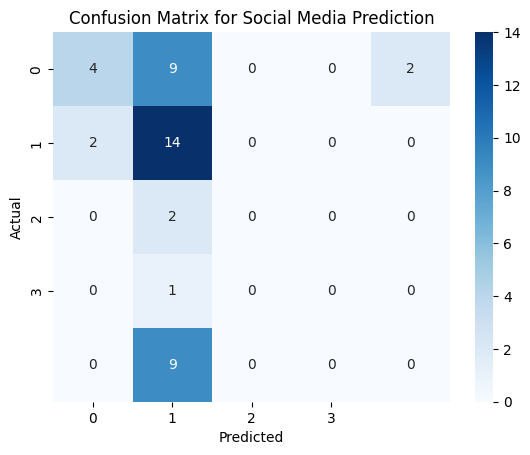

Cross-validation scores: [0.44186047 0.46511628 0.4047619  0.45238095 0.30952381]
Average accuracy: 0.41472868217054265


In [116]:
#LOGREG WITH 0.15

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Initialize the scaler
scaler = MinMaxScaler() # turned out to be better than standard (by 2%)

# Filter the dataset to only include relevant features and the target variable
X_sm = df_encoded[relevantFeatures_sm_less]
y_sm = df_encoded['SocialMediaHours']  # Use SocialMediaHours directly as target (not binary)

# Fit and transform the feature matrix
X_scaled = scaler.fit_transform(X_sm)

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_sm, test_size=0.2, random_state=42
)

# Train Logistic Regression Model (multi-class)
model_sm = LogisticRegression(max_iter=10000, random_state=42)
model_sm.fit(X_train, y_train)

# Predict on the test set
y_pred = model_sm.predict(X_test)

# Evaluate the model with classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(0, max(y) + 1)], yticklabels=[str(i) for i in range(0, max(y) + 1)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Social Media Prediction')
plt.show()

scores = cross_val_score(model_sm, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Average accuracy:", scores.mean())

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *

Best Hyperparameters: {'C': 10, 'max_iter': 1000, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.27      0.38        15
           1       0.41      0.88      0.56        16
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         9

    accuracy                           0.42        43
   macro avg       0.22      0.23      0.19        43
weighted avg       0.39      0.42      0.34        43



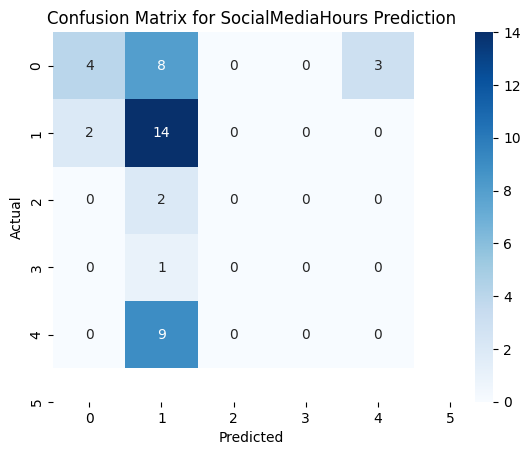

Cross-validation scores: [0.39534884 0.46511628 0.42857143 0.47619048 0.54761905]
Average accuracy: 0.46256921373200444


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default 

In [115]:
#LOG REG & GRIDSEARCH 0.15

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the scaler
scaler = MinMaxScaler()  # MinMaxScaler turned out to be better than StandardScaler (by 2%)

# Filter the dataset to only include relevant features and the target variable
X_sm = df_encoded[relevantFeatures_sm_less]
y_sm = df_encoded['SocialMediaHours']  # Use SocialMediaHours directly as target (not binary)

# Fit and transform the feature matrix
X_scaled = scaler.fit_transform(X_sm)

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_sm, test_size=0.2, random_state=42
)

# Define the hyperparameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2', 'l1'],  # L1 or L2 regularization
    'solver': ['liblinear', 'saga'],  # Solvers that support L1 and L2
    'max_iter': [1000, 5000, 10000],  # Iterations for convergence
    'multi_class': ['ovr', 'multinomial'],  # Multi-class strategy
}

# Initialize the Logistic Regression model
model_sm = LogisticRegression(random_state=42)

# Set up the GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model_sm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model from the grid search
best_model_sm = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model_sm.predict(X_test)

# Evaluate the model with classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(0, max(y_sm) + 1)], yticklabels=[str(i) for i in range(0, max(y_sm) + 1)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SocialMediaHours Prediction')
plt.show()

# Cross-validation scores with the best model from GridSearchCV
scores = cross_val_score(best_model_sm, X_scaled, y_sm, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Average accuracy:", scores.mean())

### Interpretation:
Baseline Consideration: To assess whether 50% accuracy is good, it’s important to compare it to a baseline. If one class (e.g., "Low Social Media Usage") dominates the dataset, predicting that class for all instances could result in similar or slightly lower accuracy. If the model's performance is only marginally better than such a baseline, it suggests that the model might not be capturing sufficient information about the different levels of social media usage. This comparison helps gauge if further improvements in model complexity or feature engineering are necessary.

### Data Complexity:
Social media usage can be influenced by various complex factors, including personality traits, socio-economic status, and cultural influences. Even with hyperparameter tuning and careful feature selection, the 50% accuracy could reflect the underlying complexity of the problem. The relationships between features (such as income, personality traits, or employment status) and social media usage might be nonlinear or harder to capture with logistic regression, which assumes linear relationships between features and the target.

### Feature Selection:
Features were selected based on their correlation with the target. While this helped reduce the dimensionality of the problem, correlation-based selection might overlook non-linear relationships or features that aren’t strongly correlated but still provide significant predictive power.

## Conclusion

Throughout the hackathon, we explored predictive modeling on variables such as "CigsPerDay," "TimeToFirstCig," and "SocialMediaHours". Despite attempting feature selection, advanced models (XGBoost), and hyperparameter tuning, accuracy hovered around 50-56%.

One significant limitation is the dataset size—only around 200 data points—which is quite small for building robust, generalizable models. With such limited data, even strong modeling techniques may struggle to uncover stable patterns, especially for complex human behaviors influenced by numerous subtle factors.

**Key Takeaways:**

1. **Data Complexity & Quantity:** Human behaviors like smoking intensity or social media patterns are complex. With only ~200 samples, the model may not have enough examples to learn meaningful, generalizable relationships. Acquiring more data could significantly improve model performance and stability.

2. **Feature Engineering & Data Enrichment:** The relatively low accuracy indicates a need for richer or more relevant features. Additional data collection or domain-informed feature engineering might help the model capture the underlying patterns more effectively.

3. **Modeling Strategies:** While advanced algorithms can help, no model can compensate fully for limited and potentially unrepresentative data. More sophisticated modeling approaches, handling ordinal targets better, or incorporating expert domain knowledge could be beneficial.

**In essence**, our attempts serve as a starting point. Although the current models’ accuracy is modest, the exercise has highlighted the complexity of the task, the importance of sufficient data, and the need for more comprehensive feature development. As a next step, increasing the sample size and exploring additional feature engineering approaches are likely to yield more meaningful improvements.
